# Using sparse convolutions to generate noisy inputs

> **NOTE** Within Jupyter Lab, this notebook is best displayed with [`jupyterlab-myst`](https://myst-tools.org/docs/mystjs/quickstart-jupyter-lab-myst).

## Basic principle

:::{note}
:class: margin
We are interested here in 1-d signals, but this algorithm generalizes easily to $n$-d. The $n$-d form is the one found in [(Lewis, 1989)](https://doi.org/10.1145/74333.74360).
:::
The sparse convolution algorithm [(Lewis, 1989)](https://doi.org/10.1145/74333.74360) is an effective way to generate a noise signal with a prescribed covariance.
Moreover, it produces a so-called “solid noise”: a continuous function which can be evaluated at any $t$.[^sparse-noise] This algorithm was originally designed to produce computationally efficient, naturalistic noise for computer graphics, but the same features make it uniquely suited for use as an input noise when integrating systems with standard ODE integrators. Even integrators which adapt their step size are supported.

The idea is to generate the desired signal $ξ$ by convolving a kernel $h$ with a Poisson noise process $γ$:
\begin{equation}
ξ(t) = h \ast γ = \int h(t-t') γ(t') \,dt' \,.
\end{equation}
The Poisson noise is defined as

$$γ(t) = \sum_k a_k \, δ(t - t_k) \,, $$ (eq_Poisson-noise_no-bins)

where both the weights $a_k$ and the impulse times $t_k$ are stochastic and uncorrelated. (It particular this means that the distribution of $a_k$ should satisfy $\braket{a_k} = 0$.) Because the impulses are sparse, the convolution reduces to an efficient summation:
\begin{equation}
ξ(t) = \sum_k a_k h(t - t_k) \,,
\end{equation}
and the autocorrelation is given by
\begin{equation}
\bigl\langle{ξ(t)ξ(t-t')}\bigr\rangle = \sum_k \Braket{a_k^2} h(t-t_k)h(t'-t_k) \,.
\end{equation}

[^sparse-noise]: Contrast this with a standard scheme of generating white noise by drawing from a Gaussian with variance $Δt σ^2$: these generate noisy inputs $ξ_n$, which represent the integrals $\int_{nΔt}^{(n+1)Δt} ξ(t) dt$, but to generate an intermediate point for $ξ((n+\tfrac{1}{2})Δt)$, one needs to draw a new point: there is no deterministic rule to compute a dense $ξ(t)$ from a sparse set of $ξ_n$. One can of course interpolate the $ξ_n$, but the result has non-physical statistics: the autocovariance depends not just on the distance between points, but also on how they line up to the arbitrary grid of reference points $ξ_n$.

:::{admonition} Remark

Assuming the derivatives of the kernel function are known, derivatives of the generated noise are also easy to evaluate:

$$ξ^{(n)}(t) = \sum_k a_k h^{(n)}(t-t_k)$$

:::

:::{admonition} Notation
:class: hint, margin

We use
\begin{equation*}
\small \tilde{ξ}(ω) = \frac{1}{\sqrt{2π}}\int e^{-iωt} ξ(t)\,dt
\end{equation*}
to denote the Fourier transform of $ξ$, and
\begin{align*}
\small S_{ξξ}(ω) &= \lvert \tilde{ξ}(ω) \rvert^2 \\
&= \frac{1}{\sqrt{2π}}\int\!dt\,e^{-iωt} \braket{ξ(t)ξ(t-τ)}_τ
\end{align*}
to denote its power spectrum.[^wiener-kinchine]

[^wiener-kinchine]: The equality of the power spectrum with the Fourier transform of the correlation function follows from the Wiener-Kinchine theorem, and the fact that these are wide-sense-stationary processes.
:::
Moreover, the power spectrum $S_{γγ}$ of $γ$ is flat:
\begin{align*}
\Bigl\langle{γ(t)γ(t')}\Bigr\rangle &= \bigl\langle{a^2}\bigr\rangle \, δ(t-t') \\
S_{γγ}(ω) &= \frac{1}{\sqrt{2π}} \int \Braket{γ(t)γ(t')} e^{-iωt} \,dt = \frac{ρ\braket{a^2}}{\sqrt{2π}}
\end{align*}
which is why $γ$ is referred to as a sparse white noise.

In particular this means that the power spectrum of the autocorrelation $\braket{ξ(t)ξ(t')}$ is proportional to that of $h$:[^sloppy-power-spectrum][^mistake-in-Lewis]
\begin{align*}
S_{ξξ}(ω) &= S_{γγ}(ω) S_{hh}(ω) \\
&= \frac{ρ\braket{a^2}}{\sqrt{2π}} S_{hh}(ω) \\
&= \frac{ρ\braket{a^2}}{\sqrt{2π}} \lvert \tilde{h}(ω) \rvert^2 \,.
\end{align*}

[^sloppy-power-spectrum]: This result is easily seen if we assume the Fourier transform of both $γ$ and $h$ to exist. Then using the result that the Fourier transform converts convolutions into products, we have  
  $\displaystyle
  S_{ξξ}(ω) = \lvert \tilde{ξ}(ω) \rvert^2 = \lvert \tilde{h}(ω) \tilde{γ}(ω) \rvert^2 = \lvert \tilde{γ}(ω) \rvert^2  \lvert \tilde{h}(ω) \rvert^2  \,.
  $  
  However the equality of the power spectra is even more general, since it applies even when the Fourier transforms don't exist. This is useful here, because $γ$ is stochastic: therefore does not have a well-defined Fourier transform, but it does have an autocorrelation function.

[^mistake-in-Lewis]: In Lewis this is given as $S_{y}(ω) = S_x(ω) \lvert H(jω)\rvert^2$, with $S_y = S_{ξξ}$, $S_x = S_{γγ}$, $j = i$ and $H$ the Fourier transform of $h$. As far as I can tell the presence of the imaginary factor $j$ is a mistake: at least in the case where the Fourier transform of $γ$ exists, it does not appear (see above footnote). Possibly this is due to the fact that in the study of LTI (linear time-invariant) systems, often the *Laplace* transform of a kernel $h$ is written $H$; then the Fourier transform is written $H(iω)$ (or $H(jω)$ in engineering notation). See e.g. [here](https://en.wikipedia.org/wiki/Linear_time-invariant_system#Fourier_and_Laplace_transforms).

To get the correlation function, we can use the Wiener-Khinchine theorem: applying the inverse Fourier transform to $S_{ξξ}$ will yield the autocorrelation:
\begin{equation}
C_{ξξ}(t) = \Bigl\langle{ξ(t)ξ(t+s)\Bigr\rangle} = \frac{ρ\braket{a^2}}{\sqrt{2π}} \mathcal{F}^{-1}\bigl\{\,\lvert\tilde{h}\rvert^2 \,\bigr\} \,.
\end{equation}
In general this is not possible to do analytically, but for particular choices of $h$ it is.
Perhaps the most obvious one is a Gaussian kernel; then $h(s)$, $\tilde{h}(ω)$, $|\tilde{h}(ω)|$ and $C_{ξξ}(s)$ are all Gaussian.
Another one would be a boxcar kernel. In general, if we have a function $\tilde{h}(ω)$ for which the Fourier transforms of both $\tilde{h}(ω)$ and $|\tilde{h}(ω)|^2$ are known, then it is possible to select the kernel given the desired autocorrelation length.

:::{admonition} Possible further work
:class: dropdown

**Usability**

- *Support for function arithmetic,* so that e.g. noises with different correlation times can be added together into one noise function. Possibly we could achieve this just by making our noise a subclass of [`scityping.PureFunction`](https://github.com/alcrene/scityping/blob/cc760c9ab009b419f90442a2c3ce24fd272fd945/scityping/functions.py#L276). Some considerations:
  - Adding a bias seems like an obvious use case. In this case, the autocovariance and autocorrelation (which are no longer the same) can be trivially obtained from the autocorrelation of the original unbiased noise. Should the returned object then still proved statistics and methods, like the autocorrelation time `.τ` and the autocorrelation function `.autocorr` ? (If so, we should probably add a `.autocov` method.)

- *Allow online generation of noise samples:* the current implementation requires to pre-specify `t_min` and `t_max`, but this is only for convenience and because it was natural to do so in my use cases. Some ideas:
    - Store impulse times and weights in a cyclic buffer, allowing for infinite generation forward in time.
    - Design a scheme which assigns to each bin a unique seed, computed from $t$. When a time is requested, generate the required impulses and compute the noise value. This would allow random access on an infinite time vector. With suitable caching, it could also be used for a generator which allows infinite iteration both forward *and* backward in time.

**Functionality**

- *Support for multivariate output with specified cross-correlation.* (Currently only multivariate output with independent components is supported.)

- *Support for more kernels.* One kernel that may be desirable is the exponential, $h(s) = e^{-|s|/τ}$, since often we think of correlation length as the scale of an exponential decay. We find then that $\tilde{h}(ω)$ should be a Lorentz distribution, for which unfortunately $C_{ξξ}(s) = \mathcal{F}^{-1}\bigl\{\,|\tilde{h}(ω)|^2\,\}$ does not Fourier transform easily.[^no-Lorentz-kernel] However, numerical experiments suggest that $C_{ξξ}(s)$ looks an awful lot like a Lorentz distribution – perhaps a suitable approximation could formalize the correspondence. A Lorentzian autocorrelation would be an interesting complement to the Gaussian since it has very different satistics (in particular very heavy tails), and is a frequent alternative to the Gaussian is many applications.

- *Support for arbitrary autocorrelation,* by using FFT to compute the kernel $h$:
  \begin{equation*}
    \begin{CD}
    S_{ξξ}(ω) = |\tilde{h}(ω)|^2 @>{\sqrt{}}>>  h(ω)   \\
    @AA{\mathcal{F}}A                 @VV{\mathcal{F}^{-1}}V  \\
    C_{ξξ}(s)                    @.        h(s)  @>\text{smooth}>>  \bar{h}(s)
    \end{CD}
  \end{equation*}
  This would not be as fast or exact as a class tailored to a specific kernel, but might still have a few advantages over the more common approach of sampling Fourier coefficients:
    - While sampled spectra are by design non-smooth (or even non-continuous), here both the original function ($C_{ξξ}$) and the estimate ($h$) are functions of time. It is therefore more reasonable to apply smoothing, which might help remove artifacts introduced by the FFT.
    - Because we are estimating a *kernel* with FFT, and not the signal itself, we can still generate noise signals of arbitrary length and in an online fashion.
    - Once computed over discretized time, the estimated kernel $h$ could be replaced by something like a spline, making dense evaluation reasonably cheap.
    
- *Support for arbitary spectra.* This is the same as above, except that we specify $S_{ξξ}(ω)$ instead of $C_{ξξ}$.

**Theoretical**

- *Analytically characterize the effect of the impulse density parameter $ρ$.* This would give more accurate guidance in choosing an appropriate value for that parameter.


[^no-Lorentz-kernel]: Interestingly, using a Lorentz kernel instead *does* result in a fully solvable set of equations. Unfortunately, the resulting noise does not look like one would expect, and its statistics don’t converge (at least not within a reasonable amount of time). Which isn’t so surprising given the number of pathologies associated to the Lorentz distribution (infinite variance, undefined mean…)
:::

:::{admonition} Summary
:class: important

- To generate a noise $ξ$ with an given autocorrelation *spectrum*, we need to choose a kernel $h$ with the same autocorrelation spectrum (up to some constant).
- This constant is proportional to the variance of the weights $a$.
:::

## Comparison with other methods

::::{grid} 1 1 2 2

:::{grid-item-card} Sparse convolution
- ✔ Can use a standard ODE integrator.
- ✔ Dense output: Can be evaluated at arbitrary $t$.
- ✔ Technically simple.
- ✔ Large amount of control over the autocorrelation function.
- ✘ Autocorrelation function is controlled via its spectrum. In general closed form expressions relating a kernel $h$ to a autocorrelation $C_{ξξ}$ do not exist.
- ✔ Online algorithm: can easily generate new points.
- ✔ Fast: Number of operations per time point is in the order of $\mathcal{O}(5mρ)$, where $m$ is the number of neighbouring bins we sum over and $ρ$ is the number of impulses per bin.
  In particular, this is independent of the total simulation time.
:::

:::{grid-item-card} Integrating Wiener noise
- ✘ Requires a stochastic (SDE) integrator.
- ✘ Sparse trace: trace is composed of discrete time steps. Generating a new intermediate point requires re-integrating everything after that point.[^why-no-ode-integrator]
- ✔ Borderline trivial, if one is familiar with stochastic integrals.
  Otherwise conceptually and technically difficult.
- ✔ The autocorrelation is known: it is determined by the number of surrogate variables added for the integrals.
- ✘ Limited control over the correlation function: limited to those obtainable by adding a reasonable number of surrogate variables.
- ✔ Online algorithm: can easily generate new points.
- ✔ Very fast: New points are generated by drawing a Gaussian and performing a few sums.  
  However, the need to use a low-order stochastic integrator may inflate computation time.
:::

[^why-no-ode-integrator]: This is the main reason this method cannot be used with a normal ODE integrator.

:::{grid-item-card} Generating random spectra
- ✔ Can use a standard ODE integrator (I think).
- ✔ Dense output possible: If we represent as a sum of sine waves instead of the FFT vector, the function can be evaluated at arbitrary $t$.
  However the spectrum is only valid above some time resolution $Δt$.
- ✔ Full, direct control over the autocorrelation shape.
- ✘ Technically difficult: It is difficult to get the FFTs to scale exactly right, and they introduce many numerical artifacts.
- ✘ Scales poorly with the length of simulated time (because of the required FFT).
- ✘ Fixed simulation time: cannot generate new points to extend the trace.
- ✔ Moderately fast during evaluation: Number of operations scales with the number of sine components (and therefore both the resolution $Δt$ and the total simulation time).
:::

:::{grid-item-card} Perlin noise
- ✘ Intended for computer graphics: designed for numerical efficiency, not to have well-characterized statistics (beyond “they look nice”).
- Similarly, existing libraries which implement Perlin noise are intended for computer graphics, and I would not consider them suitable for scientific applications since the statistics are difficult to characterize.
- I didn’t consider this further: one would need to write their own “scientific-grade” noise model, in which case they might as well use a simpler algorithm like the sparse convolutions.
:::

::::

## Implementation

:::{admonition} Important note for JAX users
:class: important dropdown

The `__call__` method below is coded such that it can be used inside a
jitted JAX function. Since `jax.numpy` is already 99% compatible
with NumPy, mostly this means using `jnp` instead of `np`.
The main exception is slicing: we need to slice based on a computed index,
which `jax.numpy` arrays do not support (they only support static indices.)
For this we use the lower-level `lax.dynamic_slice`.

The benefit of supporting JAX is mostly when the noise output is used within
a larger, more costly function. Being JAX-compatible means we allow that
entire function to be jitted. 
When used on its own, the noise generator is fast enough that in most cases it
probably does not benefit from JIT compilation. Therefore we don't want to force
a dependency on JAX. We achieve this by defining a few fallbacks in the
`except ImportError` branch below, which is executed when JAX is not installed:
- All calls to `jnp` are redirected to `np`.
- We define `lax.dynamic_slice` to redirect to normal NumPy slicing.

In practice, if JAX is installed, JAX arrays and operations are used when
evaluating the noise; otherwise NumPy arays and operations are used.
**In particular, this means that when the `jax` library is installed, results
are always returned as JAX arrays – even if all arguments are NumPy arrays.**
We presume that a user who has already installed JAX should know to cast
results back to NumPy arrays if needed.
:::

In [1]:
from collections.abc import Callable
from dataclasses import dataclass
from typing import Union

import copy
import math
import numpy as np
import numpy.random as random
from numpy.typing import ArrayLike
try:
    import jax.numpy as jnp
    import jax.lax as lax
except ImportError:
    jnp = np
    class lax:
        @staticmethod
        def dynamic_slice(operand, start_indices, slice_sizes):
            slcs = tuple(slice(i,i+l) for i, l in zip(start_indices, slice_sizes))
            return operand[slcs]

In [35]:
from scityping.pint import Quantity

In [37]:
# Optional serialization dependencies with fallbacks
# (If these are not available, the noise objects still work, they just
# can’t be serialized.)
try:
    import pint
except ImportError:
    class pint:
        class Quantity:
            pass
try:
    from scityping import Serializable
    from scityping.numpy import Array, RNGenerator
    from scityping.pint import Quantity
    from scityping.pydantic import BaseModel
except ImportError:
    Serializable = object
    BaseModel = object
    class Quantity:
        pass

__all__ = ["ColoredNoise"]

One small complication with the definition in Eq. {eq}`eq_Poisson-noise_no-bins` for the Poisson noise is that for a given $t$, we don’t know which $t_k$ are near enough to contribute. And for a long time trace, we definitely don’t want to sum tens of thousands of impulses at every $t$, when only a few dozen contribute. So following [Lewis (1989)](https://doi.org/10.1145/74333.74360), we split the time range into bins and generate the same number of impulses within each bin. Then for any $t$ we can compute with simple arithmetic the bin which contains it, and sum only over neighbouring bins.

### `ColoredNoise`

The default `ColoredNoise` class produces noise with a Gaussian kernel, Gaussian weights $a$, and a Gaussian autocorrelation:

Parameters
~ + $τ$: Correlation time. Equivalent to the *standard deviation* of the autocorrelation function.
  + $σ$: Overall noise strength; more specifically its standard deviation: $\braket{ξ(t)^2} = σ^2$.
  + $ρ$: Impulse density, in units of $\frac{\text{# impulses}}{τ}$. For numerical reasons this must be an integer.  
    This affects what Lewis calls the “quality” of the noise; a too low number will show artifacts (high peaks), which only disappear after averaging many bins or realizations.
    Note that increasing $ρ$ does not cause the noise to wash out, but rather the effect saturates: Lewis reports that generated noises stop being distinguishable when $ρ$ is greater than 10. In my own tests I observe something similar, even though my implementation is quite different.
    Part of the reason for this is that we scale the variance of the $a_k$ to keep the overall variance of $ξ$ constant.

:::{admonition} TODO
:class: warning margin

Add expression for $S_{ξξ}$.
:::

Autocorrelation
~ $\displaystyle C_{ξξ}(s) = σ^2 e^{s^2/2τ^2}$
~ Accessible as `.autocorr`

Kernel
~ $\displaystyle h(s) = e^{-s^2/τ^2}$
~ Accessible as `.h`

Weight distribution
~ $\displaystyle a_k \sim \mathcal{N}\left(0, σ \sqrt{\frac{1}{ρ}\sqrt{\frac{2}{π}}} \right)$
~ Pre-computed within `__init__`

Binning
~ *Bin size:* $τ$
~ *Summation:* 5 bins left and right of $t$ (so a total of 11 bins)

:::{note}
:class: margin

“non-factored” refers to an previous implementation where all operations in `__call__` were performed with united values, instead of factoring out the units as `_t_unit` and `_ξ_unit` attributes and only adding them at the end. At the time I didn’t run the test with $ρ=1000$, which is why it is missing from the table.
:::

:::{list-table} Anecdotal timings ($t$ scalar, $ξ$ scalar)
:header-rows: 1
:stub-columns: 1

* -
  - $ρ=10$
  - $ρ=30$
  - $ρ=100$ 
  - $ρ=400$
  - $ρ=1000$
* - Intel Xeon W-2265, 3.50GHz  
    No units
  - 9.2 ± 0.06 μs
  - 10.2 ± 0.08 μs
  - 12.3 ± 0.07 μs
  - 19.0 ± 0.11 μs
  - 32.1 ± 0.45 μs
* - Intel Xeon W-2265, 3.50GHz  
    With *pint* units, non-factored
  - 270 ± 2.7 μs
  - 273 ± 1.6 μs
  - 290 ± 3.0 μs
  - 311 ± 4.3 μs
  -
:::

In [ ]:
def recreate_rng(rng_state: dict) -> np.random.Generator:
    """Recreate a NumPy Generator from its bit_generator state.
    
    Ported from scityping.numpy.RNGenerator.
    """
    bg = getattr(np.random, rng_state["bit_generator"])()
    bg.state = rng_state
    return np.random.Generator(bg)

In [ ]:
class ColoredNoise(Serializable):
    """
    Simplified solid noise with some predefined choices: exponential kernel :math:`h`
    and Gaussian weights :math:`a`. The specification parameters are the overall variance σ²,
    the correlation time τ and the number of impulses in a time interval of length τ.
    
    Note
    ----
    This class supports specifying values with units specified using the `pint` library.
    This is an excellent way of avoiding some common mistakes. When doing so, all units
    must be consistent; in particular, ``t/τ`` must be dimensionless in order for the
    exponential to be valid.
    Using units does add a bit of overhead, so for performance-critical code omitting
    them may be preferred.
    """

    # Inspection attributes (not uses when generating points)
    _σ: float                                # Stored without units
    _τ: float                                # Stored without units
    ρ: float
    _bin_edges: np.ndarray[float]
    _t_max: float                            # Stored without units
    # rng: np.random.Generator
    _rng_state: "np.random.Generator->state"  # Restore with `recreate_rng`
    _t_unit: Union[int, pint.Quantity]
    _ξ_unit: Union[int, pint.Quantity]
    # Attributes used when generating noise
    _t_min: float                            # Stored without units
    _λ: float                                # Stored without units
    _t_arr: np.ndarray[float]                # Stored without units
    _a_arr: np.ndarray[float]                # Stored without units
    
    
    def __init__(self,
                 t_min    : Union[float,pint.Quantity],
                 t_max    : Union[float,pint.Quantity],
                 corr_time: Union[float,pint.Quantity],
                 scale: ArrayLike, 
                 impulse_density: int,
                 rng: Union[int,random.Generator,random.SeedSequence,None]=None):
        """
        Multivariate outputs can be generated by passing an array of appropriate shape
        as the `scale` parameter. Each component is uncorrelated with the others, so
        this is equivalent (but faster) to generating N independent noise sources.
        
        Parameters
        ----------
        t_min, t_max: Determine the window of time within which to generate noise.
           The noise function can still be called outside this window, but decays
           to zero the further we are from the window.
           (Specifically, `t_min` and `t_max` determine the window of the underlying
           Poisson noise process γ. We take care to extend the window sufficiently
           so that the noise quality is the same from `t_min` to `t_max`.)
        corr_time: Correlation time (τ). If the kernel is given by :math:`e^{-λ|τ|}`,
           this is :math:`τ`.
        scale: (σ) Standard deviation of the generated noise.
           The shape of `scale` determines the shape of the output.
        impulse_density: (ρ) The expected number of impulses within one correlation
           time of a test time.
        rng: Either a random seed, or an already instantiated NumPy random `Generator`.

        .. Note::
           To specify units, use `pint.Quantities` objects for the parameters
           `t_min`, `t_max`, `corr_time` and/or `scale`.

           - `t_min`, `t_max` and `corr_time` determine the units of the input.
             They must have matching units ('ms' and 's' is fine, but not 'ms' and 'km').
           - `scale` determines the units of the output.
        """
        ### Convention: '_' prefix means without units
        
        rng = random.default_rng(rng)
        if not isinstance(rng, np.random.Generator):
            raise TypeError("Please use a `numpy.random.Generator` for the RNG, "
                            f"or just specify a seed.\nReceived {type(rng)}.")
        # Store the RNG state so the noise can be serialized & recreated
        self._rng_state = rng.bit_generator.state
        
        self._t_unit = getattr(corr_time, "units", 1);
        self._ξ_unit = getattr(scale, "units", 1);
        
        # Compute the std dev for the weights
        _σ = jnp.asarray(getattr(scale, "magnitude", scale))
        τ, ρ = corr_time, impulse_density
        _a_std = _σ * jnp.sqrt(1/ρ) * (2/np.pi)**(0.25)
        
        # Ensure τ is in the same units as t_arr
        if hasattr(τ, "units"):
            if not hasattr(t_min, "units") or not hasattr(t_max, "units"):
                raise ValueError("If `corr_time` is specified with units, then also `t_min` and `t_max` must have units.")
            t_min = t_min.to(τ.units)
            t_max = t_max.to(τ.units)
            
        # Define unitless vars
        _t_min = getattr(t_min, "magnitude", t_min)
        _t_max = getattr(t_max, "magnitude", t_max)
        _τ = getattr(τ, "magnitude", τ)
        
        # Discretize time range into bins of length τ
        # Following Lewis, we draw the impulses in bins.
        # Each bin has exactly the same number of impulses, allowing us in __call__ to
        # efficiently restrict ourselves to nearby points.
        # NB: We always take 5 bins to the left and right, so we also pad that many bins.
        Nbins = math.ceil((_t_max - _t_min) / _τ) + 10
        _self_t_min = _t_min - 5*_τ
        #_self_t_max = self_t_min + (Nbins+1)*_τ
            
        # Draw the impulse times
        # First axis: bins
        # Second axis: impulses in that bin
        # All subsequent axes: shape of σ (and of output)
        _bin_edges = np.arange(Nbins+1) * _τ + _self_t_min  # We use all dimensionless variables here
        a_axes = (np.newaxis,)*_σ.ndim
        impulse_data_shape = (Nbins, impulse_density, *_σ.shape)
        _t_arr = rng.uniform(_bin_edges[(slice(None,-1),np.newaxis,*a_axes)], _bin_edges[(slice(1,None),np.newaxis,*a_axes)],
                             size=impulse_data_shape
                            )
        
        # Draw the weights
        _a_arr = rng.normal(0, _a_std, impulse_data_shape)
        
        # Store attributes
        self._σ = _σ
        assert self._σ.shape == np.shape(_a_std)
        self._τ = _τ
        self.ρ = ρ
        self._λ = 1/self._τ  # With floating point numbers, multiplication is faster than division
        # self.rng = rng
        self._bin_edges = _bin_edges
        self._t_min = _t_min
        self._t_max = _t_max
        self._t_arr = _t_arr
        self._a_arr = _a_arr
        
        # Precomputed window sizes
        pad=5
        self._bin_t_size = (2*pad+1, _t_arr.shape[1])
        self._bin_data_start = (0,)*_σ.ndim
        
    def __call__(self, t, *, pad=5, exp=jnp.exp, int32=jnp.int32):
        # Compute the index of the bin containing t
        if hasattr(t, "units"):
            t = t.to(self._t_unit).magnitude
        i = (t-self._t_min) * self._λ; i = getattr(i, "magnitude", i)  # Suppress Pint warning that int32 removes dim
        i = int32(i) + pad
        # Compute the noise at t
        #tk = self.t_arr[i-pad:i+pad+1]
        #a = self.a_arr[i-pad:i+pad+1]
        size = self._bin_t_size + self._σ.shape
        tk = lax.dynamic_slice(self._t_arr, (i-pad, int32(0)) + (0,)*self.σ.ndim, size)
        a  = lax.dynamic_slice(self._a_arr, (i-pad, int32(0)) + (0,)*self.σ.ndim, size)
        h = exp(-((t-tk)*self._λ)**2)  # Inlined from self.h
        return (a * h).sum(axis=(0,1)) * self._ξ_unit   # The first two dimensions are time. Extra dimensions are data dimensions, which we want to keep
    
    def new(self, rng=None, **kwargs):
        """Create a new model, using the values of this one as defaults.
        
        NB: Unless specified, this uses the RNG returned by `np.random.default_rng()`.
            This is independent of whether an RNG was given when creating the original
            noise object. Use the `rng` keyword to control the state of the RNG, or
            ensure that the noise is reproducible.
        """
        rng = np.random.default_rng(rng)
        defaults = dict(t_min=self.t_min, t_max=self.t_max, corr_time=self.τ,
                        scale=self.σ,
                        impulse_density=self.ρ, rng=rng)
        return ColoredNoise(**(defaults | kwargs))
    
    def h(self, s):
        return np.exp(-(s*self.λ)**2)
    
    def autocorr(self, s):
        """Evaluate the theoretical autocorrelation at lag s."""
        if not hasattr(s, "units"):
            s = s * self._t_unit
        return self.σ**2 * np.exp(-0.5*(s*self.λ)**2)
    
    @property
    def impulse_density(self):
        return self.ρ
    @property
    def t_arr(self):
        return self._t_arr * self._t_unit
    @property
    def t_min(self):
        return self._t_min * self._t_unit
    @property
    def t_max(self):
        return self._t_max * self._t_unit
    @property
    def a_arr(self):
        return self._a_arr * self._ξ_unit
    @property
    def τ(self):
        return self._τ * self._t_unit
    @property
    def corr_time(self):
        return self.τ
    @property
    def λ(self):
        return 1 / self.τ
    @property
    def σ(self):
        return self._σ * self._ξ_unit
    @property
    def scale(self):
        return self.σ
    @property
    def bin_edges(self):
        return self._bin_edges * self._t_unit
    
    @property
    def T(self):
        return self.t_max - self.t_min
    
    @property
    def Nleftpadbins(self):
        return 5
    @property
    def Nrightpadbins(self):
        return 5
    @property
    def Nbins(self):
        """Return the number of bins, excluding those included for padding."""
        return len(self.t_arr) - self.Nleftpadbins - self.Nrightpadbins

    def qty_to_mag(self, time=None, scale=None) -> "ColoredNoise":
        """Convert dimensioned quantities to pure magnitudes.

        Useful to provide plain arrays to low-level functions, while still
        using units for high-level functions.

        The `time` and `scale` are used to specify into which units to convert
        before retrieving the magnitude. For example, `scale` may have been
        given meters, but the low-level function expects millimeters.
        If these are not specified, then the current units are used.

        If quantities are already without units, then they are silently ignored.
        This is to allow functions to use `qty_to_mag` as a normalizer, when they
        don’t know if their argument is dimensioned.
        """
        # Define `t_unit` and `ξ_unit` as dimensionless scaling factors
        if isinstance(self._t_unit, (pint.Unit, pint.Quantity)):
            if time is None:
                t_unit = 1
            else:
                t_unit = (1*self._t_unit).to(time).m
        else:
            t_unit = 1
        if isinstance(self._ξ_unit, (pint.Unit, pint.Quantity)):
            if scale is None:
                ξ_unit = 1
            else:
                ξ_unit = (1*self._ξ_unit).to(scale).m
        else:
            ξ_unit = 1
        # Use the underlying dimensionless attributes, and multiply by scaling factors
        return ColoredNoise(t_min    =self._t_min*t_unit,
                            t_max    =self._t_max*t_unit,
                            corr_time=self._τ    *t_unit,
                            scale    =self._σ    *ξ_unit,
                            impulse_density=self.impulse_density,
                            rng      =recreate_rng(self._rng_state)
        )

    # __eq__ and __hash__are mostly implement to support caching
    # with functools.lru_cache.

    def __eq__(self, other):
        return (type(self) == type(other)
                and self.t_min == other.t_min
                and self.t_max == other.t_max
                and self.corr_time == other.corr_time
                and self.scale == other.scale
                and self.impulse_density == other.impulse_density
                and self._rng_state == other._rng_state)
    def __hash__(self):
        # NB: self._σ may be a JAX variable => we need to convert to python scalar to make it hashable
        return hash((self._t_min, self._t_max, self._τ, str(self._t_unit),
                     float(self._σ), str(self._ξ_unit),
                     self.ρ, str(self._rng_state)))

    ## Scityping serializer ##
    class Data(BaseModel):   # NB: Here we need to use the types from scityping
        t_min    : Union[float,Quantity]
        t_max    : Union[float,Quantity]
        corr_time: Union[float,Quantity]
        scale          : Union[Array,Quantity]
        impulse_density: int
        rng            : RNGenerator
        @staticmethod
        def encode(noise: "ColoredNoise"):
            return (
                noise.t_min, noise.t_max, noise.corr_time, noise.scale,
                noise.impulse_density, recreate_rng(noise._rng_state))

## Validation of theoretical expressions

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
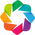

In [8]:
import itertools
import scipy.signal as signal
import holoviews as hv
import pint
from types import SimpleNamespace
from myst_nb import glue
ureg = pint.UnitRegistry()
ureg.default_format = "~P"
hv.extension("bokeh", "matplotlib")
%matplotlib inline

In [4]:
def tqdm(x, *args, **kwds): return x  # Remove progress bars when running with Jupyter Book

In [5]:
from tqdm.notebook import tqdm

In [6]:
dims = SimpleNamespace(
    t  = hv.Dimension("t", label="time", unit="ms"),
    Δt = hv.Dimension("Δt", label="time lag", unit="ms"),
    ξ  = hv.Dimension("ξ"),
    ξ2 = hv.Dimension("ξ2", label="⟨ξ²⟩"),
    T  = hv.Dimension("T", label="realization length", unit="ms"),
    σ  = hv.Dimension("σ", label="noise strength", unit="√ms"),
    τ  = hv.Dimension("τ", label="correlation length", unit="ms"),
    ρ  = hv.Dimension("ρ", label="impulse density"),
    N  = hv.Dimension("N", label="# realizations")
)
colors = hv.Cycle("Dark2").values

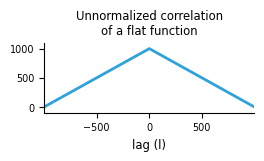

In [11]:
N = 1000
_lags = signal.correlation_lags(N, N)
norm_autocorr = hv.Curve(zip(_lags, signal.correlate(np.ones(N), np.ones(N))),
               kdims="lag (l)", vdims="C") 
norm_autocorr.opts(
    hv.opts.Curve(title="Unnormalized correlation\nof a flat function",
                  ylabel="",
                  fontsize={"title": "10pt"}),
    hv.opts.Curve(height=200, width=250, backend="bokeh"),
    hv.opts.Curve(title="Unnormalized correlation\nof a flat function",
                  ylabel="", fontsize={"title": "small", "labels": "small", "ticks": "x-small"},
                  fig_inches=3, aspect=3,
                  backend="matplotlib")
)

norm_autocorr_fig = hv.render(norm_autocorr, backend="matplotlib")
glue("norm_autocorr", norm_autocorr_fig, display=True);

In [12]:
n_realizations_shown = 10
seedseq = np.random.SeedSequence(6168912654954)
Tlst = [50.]
σlst = [0.33, 1., 9.]
τlst = [1., 5., 25.]
ρlst = [1, 5, 30, 200]
Nlst = [20]
exp_conds = list(itertools.product(Tlst, σlst, τlst, ρlst, Nlst))

In [13]:
frames_realizations = {}
frames_autocorr = {}
ms = ureg.ms

:::{admonition} Computing correlations with `scipy.signal`
:class: caution, margin, dropdown

The SciPy function `signal.correlate` (along with its companion `signal.correlation_lags` to compute the lag axis) is a convenient way to compute the autocorrelation. However before plotting the result, one must take care to normalize it correctly. Indeed, if $x$ is a discretized signal with $N$ time bins, and $C_k$ is its discretized correlation function at lag $k$, then the definition used by `correlate` is
\begin{equation}
C_k = \Braket{x_l x_{l+k}} = \sum_{l=0}^{N-1-k} x_l x_{l+k} \,.
\end{equation}
Note that the number of terms depends on $k$. We can see this clearly when computing the autocorrelation of the constant function $x_l = 1$: the result should be flat (albeit dependent on $N$), but instead we get a triangular function peaking at zero:  
{glue:}`norm_autocorr`  
where the value on the $y$ axis is exactly the number of terms contributing to that lag.
To avoid this artifical triangular decay, in the code we normalize the result by the number of terms contributing to each lag; in terms of a continuous time autocorrelation, this is equivalent to normalizing by the value at zero:
\begin{equation}
C^{\text{normed}}(s) = \frac{C(s)}{C(0)} \,.
\end{equation}
:::

In [14]:
experiment_iter = tqdm(exp_conds, "Exp. cond.")
for T, σ, τ, ρ, N in experiment_iter:
    if (T, σ, τ, ρ, N) in (frames_realizations.keys() & frames_autocorr.keys())  :
        continue
    
    noise = ColoredNoise(0, T, corr_time=τ, scale=σ, impulse_density=ρ, rng=seedseq)
    t_arr = np.linspace(noise.t_min, noise.t_max, int(10*T/noise.τ))

    ## Generate the realizations and compute their autocorrelation ##
    L = len(t_arr)
    Δt = np.diff(t_arr).mean()
    norm = signal.correlate(np.ones(L), np.ones(L), mode="same")  # Counts the number of sums which will contribute to each lag
    lags = signal.correlation_lags(L, L, mode="same") * Δt
    ξ_arr = np.empty((N, L))
    Cξ_arr = np.empty((N, L))
    for i, key in enumerate(tqdm(seedseq.spawn(N), "Seeds", leave=False)):
        _noise = noise.new(rng=key)
        ξ = np.fromiter((_noise(t) for t in t_arr), count=len(t_arr), dtype=float)
        ξ_arr[i] = ξ
        Cξ   = signal.correlate(ξ, ξ, mode="same") / norm
        Cξ_arr[i] = Cξ
    Cξ = Cξ_arr.mean(axis=0)

    ## Generator realization curves ##
    realization_samples = hv.Overlay([
        hv.Curve(zip(t_arr, _ξ), kdims=dims.t, vdims=dims.ξ, label="Single realization")
        for _ξ in ξ_arr[:n_realizations_shown]
    ])
    
    ## Generate autocorr curves ##
    autocorr_samples = hv.Overlay([
        hv.Curve(zip(lags, _Cξ), kdims=dims.Δt, vdims=dims.ξ2, label="Single realization")
        for _Cξ in Cξ_arr[:n_realizations_shown]]
    )
    avg =  hv.Curve(zip(lags, Cξ), kdims=dims.Δt, vdims=dims.ξ2, label=f"Average ({N} realizations)")
    target = hv.Curve(zip(lags, noise.autocorr(lags)), kdims=dims.Δt, vdims=dims.ξ2, label="Theoretical")
    
    ## Compute axis range so it is appropriate for mean and target autocorr – individual realizations may be well outside this range ##
    ymax = max(avg.range("ξ2")[1], target.range("ξ2")[0])
    ymin = min(avg.range("ξ2")[0], target.range("ξ2")[0])
    Δy = ymax-ymin
    ymax += 0.05*Δy
    ymin -= 0.05*Δy
    # Round ymin down, round ymax up
    p = math.floor(np.log10(ymax-ymin)) + 2  # +2: between 10 and 100 ticks in the range
    new_range = (round(math.floor(ymin * 10**p) / 10**p, p),
                 round(math.ceil (ymax * 10**p) / 10**p, p))

    ## Assemble figures ##
    # Use random shades of grey for realization curves so we can distinguish them
    shades = np.random.uniform(.45, .8, size=n_realizations_shown)
    
    fig_autocorr = autocorr_samples * avg * target
    fig_autocorr.opts(ylim=new_range)
    fig_autocorr.opts(
        hv.opts.Curve(height=300, width=400),
        hv.opts.Curve("Curve.Single_realization", color="#DDD"),
        hv.opts.Curve("Curve.Average", color=colors[0]),
        hv.opts.Curve("Curve.Prescribed", color=colors[1], line_dash="dashed"),
        hv.opts.Overlay(title="Autocorrelation", legend_position="top"),
    )
    for curve, c in zip(fig_autocorr.Curve.Single_realization, shades):
        curve.opts(color=(c,)*3)
    
    fig_realizations = realization_samples
    fig_realizations.opts(
        hv.opts.Curve(height=300, width=400),
        #hv.opts.Curve("Curve.Single_realization", color="#DDD"),
        hv.opts.Overlay(title="Noise realizations", show_legend=False)
    )
    for curve, c in zip(fig_realizations, shades):
        curve.opts(color=(c,)*3)
    
    frames_realizations[(T, σ, τ, ρ, N)] = fig_realizations
    frames_autocorr[(T, σ, τ, ρ, N)] = fig_autocorr

Exp. cond.:   0%|          | 0/36 [00:00<?, ?it/s]

Seeds:   0%|          | 0/20 [00:00<?, ?it/s]

Seeds:   0%|          | 0/20 [00:00<?, ?it/s]

Seeds:   0%|          | 0/20 [00:00<?, ?it/s]

Seeds:   0%|          | 0/20 [00:00<?, ?it/s]

Seeds:   0%|          | 0/20 [00:00<?, ?it/s]

Seeds:   0%|          | 0/20 [00:00<?, ?it/s]

Seeds:   0%|          | 0/20 [00:00<?, ?it/s]

Seeds:   0%|          | 0/20 [00:00<?, ?it/s]

Seeds:   0%|          | 0/20 [00:00<?, ?it/s]

Seeds:   0%|          | 0/20 [00:00<?, ?it/s]

Seeds:   0%|          | 0/20 [00:00<?, ?it/s]

Seeds:   0%|          | 0/20 [00:00<?, ?it/s]

Seeds:   0%|          | 0/20 [00:00<?, ?it/s]

Seeds:   0%|          | 0/20 [00:00<?, ?it/s]

Seeds:   0%|          | 0/20 [00:00<?, ?it/s]

Seeds:   0%|          | 0/20 [00:00<?, ?it/s]

Seeds:   0%|          | 0/20 [00:00<?, ?it/s]

Seeds:   0%|          | 0/20 [00:00<?, ?it/s]

Seeds:   0%|          | 0/20 [00:00<?, ?it/s]

Seeds:   0%|          | 0/20 [00:00<?, ?it/s]

Seeds:   0%|          | 0/20 [00:00<?, ?it/s]

Seeds:   0%|          | 0/20 [00:00<?, ?it/s]

Seeds:   0%|          | 0/20 [00:00<?, ?it/s]

Seeds:   0%|          | 0/20 [00:00<?, ?it/s]

Seeds:   0%|          | 0/20 [00:00<?, ?it/s]

Seeds:   0%|          | 0/20 [00:00<?, ?it/s]

Seeds:   0%|          | 0/20 [00:00<?, ?it/s]

Seeds:   0%|          | 0/20 [00:00<?, ?it/s]

Seeds:   0%|          | 0/20 [00:00<?, ?it/s]

Seeds:   0%|          | 0/20 [00:00<?, ?it/s]

Seeds:   0%|          | 0/20 [00:00<?, ?it/s]

Seeds:   0%|          | 0/20 [00:00<?, ?it/s]

Seeds:   0%|          | 0/20 [00:00<?, ?it/s]

Seeds:   0%|          | 0/20 [00:00<?, ?it/s]

Seeds:   0%|          | 0/20 [00:00<?, ?it/s]

Seeds:   0%|          | 0/20 [00:00<?, ?it/s]

In [37]:
hmap_autocorr = hv.HoloMap(frames_autocorr, kdims=[dims.T, dims.σ, dims.τ, dims.ρ, dims.N])
hmap_realizations = hv.HoloMap(frames_realizations, kdims=[dims.T, dims.σ, dims.τ, dims.ρ, dims.N])
fig = hmap_autocorr + hmap_realizations
fig.opts(
    hv.opts.Layout(title=""),
    hv.opts.Curve(framewise=True, width=500),
    hv.opts.Overlay(legend_position="top")
)
fig.cols(1)

:Layout
   .HoloMap.I                  :HoloMap   [T,σ,τ,ρ,N]
      :Overlay
         .Curve.Single_realization.I                                       :Curve   [Δt]   (ξ2)
         .Curve.Single_realization.II                                      :Curve   [Δt]   (ξ2)
         .Curve.Single_realization.III                                     :Curve   [Δt]   (ξ2)
         .Curve.Single_realization.IV                                      :Curve   [Δt]   (ξ2)
         .Curve.Single_realization.V                                       :Curve   [Δt]   (ξ2)
         .Curve.Single_realization.VI                                      :Curve   [Δt]   (ξ2)
         .Curve.Single_realization.VII                                     :Curve   [Δt]   (ξ2)
         .Curve.Single_realization.VIII                                    :Curve   [Δt]   (ξ2)
         .Curve.Single_realization.IX                                      :Curve   [Δt]   (ξ2)
         .Curve.Single_realization.X                                       :Curve   [Δt]   (ξ2)
         .Curve.Average_left_parenthesis_20_realizations_right_parenthesis :Curve   [Δt]   (ξ2)
         .Curve.Theoretical                                                :Curve   [Δt]   (ξ2)
   .HoloMap.Single_realization :HoloMap   [T,σ,τ,ρ,N]
      :Overlay
         .Curve.Single_realization.I    :Curve   [t]   (ξ)
         .Curve.Single_realization.II   :Curve   [t]   (ξ)
         .Curve.Single_realization.III  :Curve   [t]   (ξ)
         .Curve.Single_realization.IV   :Curve   [t]   (ξ)
         .Curve.Single_realization.V    :Curve   [t]   (ξ)
         .Curve.Single_realization.VI   :Curve   [t]   (ξ)
         .Curve.Single_realization.VII  :Curve   [t]   (ξ)
         .Curve.Single_realization.VIII :Curve   [t]   (ξ)
         .Curve.Single_realization.IX   :Curve   [t]   (ξ)
         .Curve.Single_realization.X    :Curve   [t]   (ξ)

## Usage examples

Scale with units

In [7]:
noise = ColoredNoise(t_min    = 0. *ureg.ms,
                     t_max    =10. *ureg.ms,
                     corr_time= 1. *ureg.ms,
                     scale    = 2.2*ureg.mV,
                     impulse_density=30,
                     rng=1337)
assert noise.Nbins == 10
expected_bin_edges = np.array([-5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5., 
                               6.,  7., 8.,  9., 10., 11., 12., 13., 14., 15.])*ureg.ms
assert np.allclose(noise.bin_edges, expected_bin_edges)
noise(1.)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Array(0.7877496, dtype=float32) <Unit('millivolt')>

Scalar output

In [8]:
noise = ColoredNoise(t_min    =   0. *ureg.ms,
                     t_max    =1000. *ureg.ms,
                     corr_time=   1. *ureg.ms,
                     scale    =   2.2,
                     impulse_density=30)
ξ = np.array([noise(t) for t in np.linspace(noise.t_min, noise.t_max, 1000)])
ξ.std(axis=0)

2.2658672

1d output

In [9]:
noise = ColoredNoise(t_min    =   0. *ureg.ms,
                     t_max    =1000. *ureg.ms,
                     corr_time=   1. *ureg.ms,
                     scale    =np.array([2.2, 1.1]),
                     impulse_density=30)
ξ = np.array([noise(t) for t in np.linspace(noise.t_min, noise.t_max, 1000)])
ξ.std(axis=0)

array([2.321867 , 1.0800734], dtype=float32)

2d output

In [10]:
noise = ColoredNoise(t_min    =   0. *ureg.ms,
                     t_max    =1000. *ureg.ms,
                     corr_time=   1. *ureg.ms,
                     scale    =[[2.2, 1.1],
                                [3.3, 4.4]],
                     impulse_density=30)
ξ = np.array([noise(t) for t in np.linspace(noise.t_min, noise.t_max, 1000)])
ξ.std(axis=0)

array([[2.1003764, 1.1283748],
       [3.256555 , 4.519454 ]], dtype=float32)

## Serialization

In [28]:
from scityping.pydantic import BaseModel

In [39]:
noise = ColoredNoise(t_min    =   0. *ureg.ms,
                     t_max    =1000. *ureg.ms,
                     corr_time=   1. *ureg.ms,
                     scale    =np.array([2.2, 1.1]),
                     impulse_density=30)

In [40]:
data = Serializable.deep_reduce(noise)
data

('__main__.ColoredNoise',
 {'t_min': 0.0 <Unit('millisecond')>,
  't_max': 1000.0 <Unit('millisecond')>,
  'corr_time': 1.0 <Unit('millisecond')>,
  'scale': array([2.2, 1.1], dtype=float32),
  'impulse_density': 30,
  'rng': Generator(PCG64) at 0x7FFA3944ADC0})

In [41]:
noise2 = Serializable.validate(data)
noise2

In [46]:
tarr = np.linspace(0, 1, 5)
assert np.array_equal([noise(t) for t in tarr],
                      [noise2(t) for t in tarr])

In [48]:
class Foo(BaseModel):
    noise: ColoredNoise

In [49]:
foo = Foo(noise=noise)
foo.json()

'{"noise": ["__main__.ColoredNoise", {"t_min": ["scityping.pint.PintQuantity", {"data": [0.0, [["millisecond", 1]]]}], "t_max": ["scityping.pint.PintQuantity", {"data": [1000.0, [["millisecond", 1]]]}], "corr_time": ["scityping.pint.PintQuantity", {"data": [1.0, [["millisecond", 1]]]}], "scale": ["scityping.numpy._ArrayType", {"data": ["scityping.numpy.ListArrayData", [["scityping.base_types.Type", {"module": "scityping.numpy", "name": "ListArrayData"}], {"data": [2.200000047683716, 1.100000023841858], "dtype": ["scityping.numpy.DType", {"desc": "float32"}]}]]}], "impulse_density": 30, "rng": ["scityping.numpy.RNGenerator", {"bit_generator": "PCG64", "state": {"state": 286938187503198264467393134251961565734, "inc": 67261109567213725899501683492449459991}, "has_uint32": 0, "uinteger": 0, "buffer": null, "buffer_pos": null}]}]}'

In [50]:
foo2 = foo.parse_raw(foo.json())

In [51]:
assert np.array_equal([foo.noise(t) for t in tarr],
                      [foo2.noise(t) for t in tarr])